# Special Session: Noise Characterization and Error Mitigation in Near-Term Quanutm Computers

* Christopher J. Wood (cjwood@us.ibm.com)
* IBM Quantum, T. J. Watson Research Center, Yorktown Heights, USA

This notebook contains the accompanying code to the ICCD 2020 special session proceeding *Noise Characterization and Error Mitigation in Near-Term Quantum Computers*.

## 2. Quantum Process Tomography

This notebook demonstrates performing quantum process tomography (QPT) of a noisy implementation of a random 2-qubit unitary gate on both a real device and a noisy simulator using Qiskit.

In [1]:
# Qiskit Modules
import qiskit
import qiskit.quantum_info as qi
import qiskit.ignis.verification.tomography as tomo

# Noisy Simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

# Plotting
import numpy as np
import matplotlib.pyplot as plt

# File utilities for saving and loading JSON data
from file_utils import save_to_json, load_properties, load_result

### Generate a random 2-qubit unitary

First we generate a random 2-qubit unitary matrix. This may be done using the `random_unitary` function from the `quantum_info` module.

In [2]:
su4 = qi.random_unitary(4, seed=42)
print(su4)

Operator([[ 0.14480819+0.1752384j , -0.51892816-0.52424259j,
           -0.14955858+0.312755j  ,  0.16913481-0.50538631j],
          [-0.92717439-0.08785062j, -0.11260331-0.1818585j ,
            0.12255872+0.09640286j, -0.24498509-0.05045841j],
          [-0.00798428-0.20355071j, -0.38932055-0.05180925j,
            0.26051706+0.32864025j,  0.44517308+0.65589332j],
          [ 0.03137922+0.19613952j,  0.4980475 +0.08846049j,
            0.34078865+0.750661j  ,  0.01464807-0.15755843j]],
         input_dims=(2, 2), output_dims=(2, 2))


### Decompose the unitary into CX and single-qubit gates

Next we create a quantum circuit containing the single 2-qubit unitary gate and use the *transpiler* to `transpile` it into a set of basis gates that may be run on a backend. The set of basis gates we will use is the Controlled-X gate and single qubit gates u1, u2, u3.

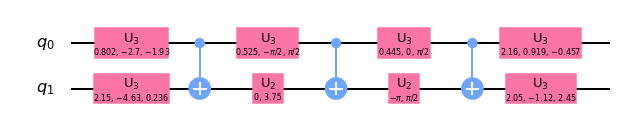

In [3]:
circuit = qiskit.QuantumCircuit(2).compose(su4, [0, 1])
circuit = qiskit.transpile(circuit, basis_gates=['u1', 'u2', 'u3', 'cx'])
circuit.draw('mpl').savefig('figures/su4_circuit.png', dpi=150)
circuit.draw('mpl')

#### Construct QPT circuits

Next we generate the quantum process tomography circuits using the `tomography` module of *qiskit-ignis*. This generates 144 circuits which prepare each qubit in one of the 4 basis states $|0\rangle, |1\rangle, |+\rangle, |-\rangle$, and measures each qubit in one of the 3 pauli bases $X, Y, Z$.

In [4]:
tomo_circuits = tomo.process_tomography_circuits(circuit, [0, 1])

An example of one of the individual measurements circuits is shown below

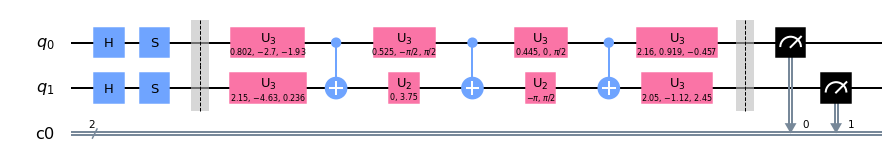

In [5]:
tomo_circuits[-1].draw('mpl')

### Run Experiment

Next execute the QPT circuits on the IBM Quantum Boeblingen backend. You may change this to run on any IBM Quantum backend you have access to.

In [6]:
use_saved_data = True
file_properties = 'data/properties_qpt_v1.json'
file_result = 'data/result_qpt_v1.json'

if use_saved_data:

    # Load saved result data from file
    result_backend = load_result(file_result)
    
    # Load saved properties from file
    properties = load_properties(file_properties)

else:

    # Load IBMQ Account data
    from qiskit import IBMQ
    IBMQ.load_account()

    # Get backend for experiment
    provider = IBMQ.get_provider(project='ignis')
    backend = provider.get_backend('ibmq_boeblingen')
    shots = 8192

    # Run QPT on backend
    job_backend = qiskit.execute(tomo_circuits, backend, shots=shots)
    print('Job ID: {}'.format(job_backend.job_id()))

    # Save a copy of the backend properties to file
    properties = backend.properties()
    save_to_json(properties, file_properties)
          
    # Retrieve results (this may take a while depending on the queue)
    result_backend = job_backend.result()
    
    # Save a copy of the result data to file
    save_to_json(result_backend, file_result)    

### Run Simulation

Next we run the QPT using the Qiskit Aer simulator with the basic device noise model based on the backend used to run the experiment

In [7]:
# Simulator backend
simulator = QasmSimulator()
shots = 8192
seed_simulator = 12345

# Noise Model
noise_model = NoiseModel.from_backend(properties, warnings=False)

result_sim = qiskit.execute(tomo_circuits,
                            simulator,
                            shots=shots,
                            seed_simulator=seed_simulator,
                            basis_gates=noise_model.basis_gates,
                            noise_model=noise_model).result()

## Fitting Results

Next we perform the tomographic fit to reconstruct the noisy quantum channel from the result data. This is done using the `ProcessTomographyFitter` from the `tomography` module.

In [8]:
choi_backend = tomo.ProcessTomographyFitter(
    result_backend, tomo_circuits).fit(method='cvx', solver='CVXOPT')

choi_sim = tomo.ProcessTomographyFitter(
    result_sim, tomo_circuits).fit(method='cvx', solver='CVXOPT')

To extract the error channel we can compose the reconstructed channel with the inverse of the ideal channel and compute the average gate fidelity

In [9]:
choi_error_backend = choi_backend.dot(su4.adjoint())
F_backend = qi.average_gate_fidelity(choi_error_backend)

choi_error_sim = choi_sim.dot(su4.adjoint())
F_sim = qi.average_gate_fidelity(choi_error_sim)

print('Average Gate Fidelity\n')
print('F({}) = {:.3f}'.format(properties.backend_name, F_backend))
print('F(simulator) = {:.3f}'.format(F_sim))

Average Gate Fidelity

F(ibmq_boeblingen) = 0.927
F(simulator) = 0.908


## Gate Error Plot

To visualize the error in the reconstructed channel we convert the error channel into the *Pauli transfer matrix* representation. In the ideal case this is an identity channel, so we subtract the identity channel to visualize the difference $|\mathcal{R} - \mathcal{I}|$.

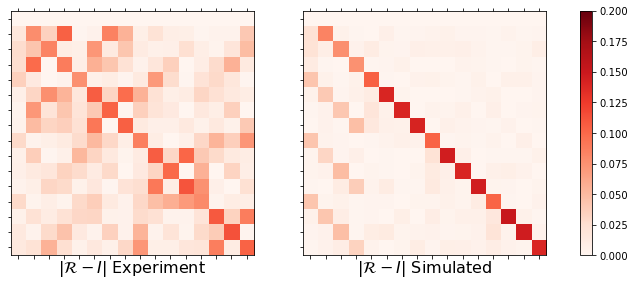

In [10]:
diff_ptm_b = np.abs(qi.PTM(choi_error_backend).data.real - np.eye(16))
diff_ptm_s = np.abs(qi.PTM(choi_error_sim).data.real - np.eye(16))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4.5))

im = axes.flat[0].matshow(diff_ptm_b, cmap=plt.cm.Reds, vmin=0, vmax=0.2)
im = axes.flat[1].matshow(diff_ptm_s, cmap=plt.cm.Reds, vmin=0, vmax=0.2)

axes.flat[0].set_xlabel(r'$|\mathcal{R} - \mathcal{I}|$ Experiment', fontsize=16)
axes.flat[1].set_xlabel(r'$|\mathcal{R} - \mathcal{I}|$ Simulated', fontsize=16)

for ax in axes.flat:
    ax.set_yticks(np.arange(16))
    ax.set_xticks(np.arange(16))
    ax.set_yticklabels(16 * [''])
    ax.set_xticklabels(16 * [''])
axes.flat[0].set_xlabel(r'$|\mathcal{R} - I|$ Experiment', fontsize=16)
axes.flat[1].set_xlabel(r'$|\mathcal{R} - I|$ Simulated', fontsize=16)

fig.colorbar(im, ax=axes.ravel())
fig.savefig('figures/qpt_ptm_diff.png', dpi=150)
plt.show()

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table